### Using the VGG image Annotator, we created bouding boxes over our defined classes.
Below are the information we get when we export the annotations project to a json file:

- "_via_settings": VIA tool settings used 
  - "ui": VIA user interface parameters
    - "annotation_editor_height": Annotation editor height(the one that pops from below) 
    - "annotation_editor_fontsize": Annotation editor font size used
    - "leftsidebar_width": Left panel width
    - "image_grid": Image grid view
      - "img_height": Image grid height
      - "rshape_fill": Fill color for the bounding region shape
      - "rshape_fill_opacity": Opacity for the bounding region
      - "rshape_stroke": Color for region boundary
      - "rshape_stroke_width": Thickness of region boundary
      - "show_region_shape": Boolean flag to make region shape visible after making.
      - "show_image_policy": Boolean flag to have all images in the project visible.
    - "image": Image specific setting tags.
      - "region_label": Bounding region label name using region id.
      - "region_color": Bounding region label name on which the color of bounding region depends.
      - "region_label_font": Font size n type of bounding region label name.
      - "on_image_annotation_editor_placement": Placement of on image pop up annotation editor.
  - "core": VIA internal core settings.
    - "buffer_size": Buffer size to preload images for smooth navigation.
    - "filepath": Multiple file path to search for images.
    - "default_filepath": Default image filepath for all the images of dataset.
  - "project": Project information
    - "name": Name of the user project
- "_via_img_metadata": Image annotaions meta data information
  - "image_098.jpg1514118": Name of the image generated by VIA using actual filename n filesize.
    - "filename": Actual image filename in directory. 
    - "size": size of image in bytes.
    - "regions": Array of bounding regions created
      - "shape_attributes": Region shape tags
        - "name": Shape Type of region made 
        [rectangular /circular /elliptical /polygon /point /polyline]
          
          For rectangular
          - "x": x-coordinate of region from bottom left
          - "y": y-coordinate of region from bottom left
          - "width": width of bounding region
          - "height": height of bounding region
          
          For circle
          - "cx": x-coordinate of center from bottom left
          - "cy": y-coordinate of center from bottom left
          - "r": radius of bounding region
          
          For ellipse
          - "cx": x-coordinate of center from bottom left
          - "cy": y-coordinate of center from bottom left
          - "rx": minor radius from bottom left
          - "ry": major radius from bottom left
          - "theta": incline angle
          
          For point
          - "cx": x-coordinate from bottom left
          - "cy": y-coordinate from bottom left
          
          For polygon n polyline
          - "all_points_x": all x-coordinate of region from bottom left
          - "all_points_x": all y-coordinate of region from bottom left
      - "region_attributes": Region specific details 
        - "class_name": "hardhat" [Region label : Region label id]
    - "file_attributes": User defined tags associated with the files
      - "used_as": "dataset" [File attribute label : label value]
      - "caption": "firefighters combating fire"
- "_via_attributes": VIA tool attributes
  - "region": Dictionary of region labels defined by user
    - "class_name": Region label name
      - "type": Label value type, can be [text, dropdown, radio, checkbox, image].
      - "description": Description of region label
      - "options": When choice type, label type is selected, provides option list
        - "hardhat": "Head gear" [Region label id : Region label value desc.]
        - "vest": "Body protective cover/gear ",
        - "mask": "Face cover",
        - "boots": "Foot gear"
      - "default_options": Default region label id after annotating
        - "hardhat": true [Boolean tag for the default region label id]
  - "file": Dictionary of file labels defined by user
    - "caption": File attribute name
      - "type": Attribute value type, can be [text, dropdown, radio, checkbox, image].
      - "description": Attribute description
      - "default_value": Attribute default value
    - "used_as": {
      - "type": "radio",
      - "description": "",
      - "options": Option choice depending upon the attribute type selected
        - "dataset": "used as a part of dataset"[Attribute value : Value desc.] 
        - "viewing": "used for viewing as examples"
      - "default_options": Default option choice
        - "dataset": true [Boolean tag for the default options file attribute]
- "_via_data_format_version": VIA tool version
- "_via_image_id_list": Array of VIA file names of images uploaded 

### To calculate the number of Anchor boxes required n their centroids we use K-means Clustering
Relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then we select the number of clusters where the change in WCSS begins to level off.
WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

In [21]:
import json
import zipfile
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [5]:
# extracting dataset
with zipfile.ZipFile("./yolo_data.zip", 'r') as yolo_dataset:
    yolo_dataset.extractall('./yolo_data')

In [2]:
with open("./EVA5_P1S12_YOLOv3.json") as annotation_file:
    annotation_meta = json.load(annotation_file)

In [6]:
image_annotation = annotation_meta['_via_img_metadata']

In [16]:
normalized_bounding_boxes = []
for via_img in image_annotation.keys():
    img_meta = image_annotation[via_img]
    img_name = img_meta["filename"]
    img_height, img_width = Image.open('./yolo_data/yolo_data/' + img_name).size
    for region in img_meta["regions"]:
        bbox_w = region["shape_attributes"]["width"]
        bbox_h = region["shape_attributes"]["height"]
        normalized_bounding_boxes.append((bbox_w / img_width, bbox_h / img_height))

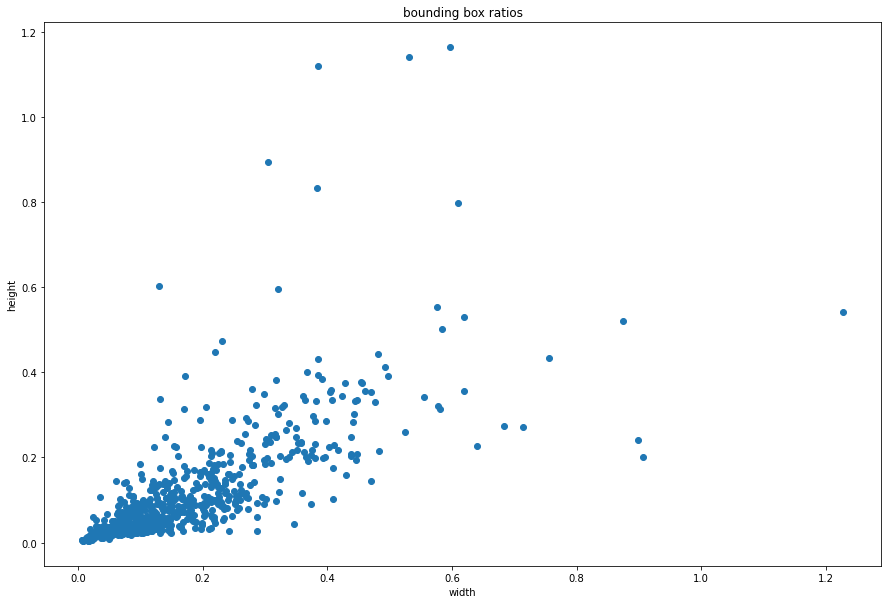

In [19]:
plt.figure(figsize=(15, 10))
norm_bboxes = np.array(normalized_bounding_boxes)
plt.scatter(norm_bboxes[:, 0], norm_bboxes[:, 1])
plt.xlabel("width")
plt.ylabel("height")
plt.title("bounding box ratios")
plt.show()


Applying KMeans to find optimal number of clusters

Using the WCSS/elbow method to find the optimal number of clusters:


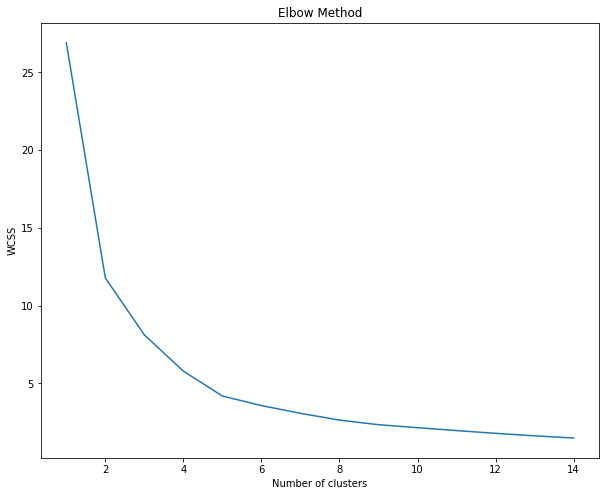

In [22]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(
        n_clusters=c,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    kmeans.fit(norm_bboxes)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

According to the elbow method we get that the optimal number of cluseters are **5** . Now, we’ll categorize the data using the clusters

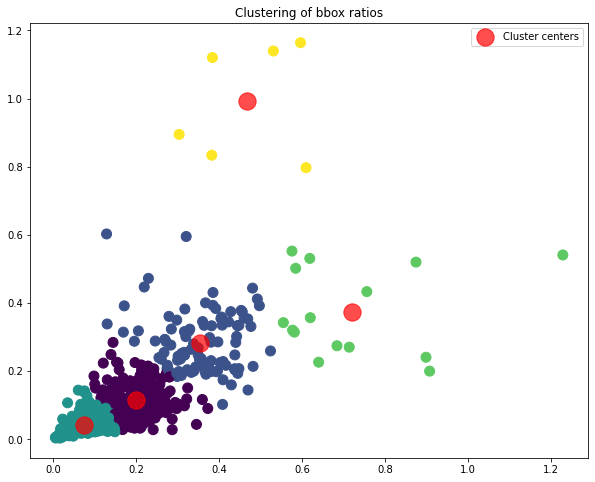

In [24]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(norm_bboxes)

plt.figure(figsize=(10, 8))
plt.scatter(norm_bboxes[:,0], norm_bboxes[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

We can use the following certroids as anchors boxes

In [25]:
kmeans.cluster_centers_

array([[0.20092359, 0.11442979],
       [0.35393096, 0.28360962],
       [0.07519644, 0.0421708 ],
       [0.72095688, 0.37498959],
       [0.46803876, 0.99154759]])